**EL DATASET: US domestic flights from 1990 to 2009
Vuelos domesticos de USA de 1990 al 2000**

| Campo                    | Descripción                                                                                     |
|--------------------------|-------------------------------------------------------------------------------------------------|
| Origin                   | Código IATA (de tres letras) del aeropuerto de origen                                           |
| Destination              | Código IATA (de tres letras) del aeropuerto de destino                                          |
| Origin City              | Nombre de la ciudad de origen                                                                   |
| Destination City         | Nombre de la ciudad de destino                                                                  |
| Passengers               | Número de pasajeros transportados desde el origen hasta el destino                              |
| Seats                    | Número de asientos disponibles en vuelos desde el origen hasta el destino                        |
| Flights                  | Número de vuelos entre el origen y el destino (varios registros por mes, muchos con vuelos > 1)    |
| Distance                 | Distancia (en millas, aproximada) volada entre el origen y el destino                             |
| Fly Date                 | La fecha del vuelo (formato aaaaMM)                                                              |
| Origin Population        | Población de la ciudad de origen según el censo de EE. UU.                                      |
| Destination Population   | Población de la ciudad de destino según el censo de EE. UU.

Usa *regresión* cuando el modelo debe predecir un *valor numérico continuo* (por ejemplo, el precio de una casa o la temperatura).

Usa *clasificación* cuando el modelo debe predecir una *categoría o clase* (por ejemplo, si un correo es spam o no, o el tipo de flor).

DEPENDE DE LA TAREA en este caso regresion para un valor continuo como el numero de pasajeros y de clasificacion para el destino del vuelo valores discretos(unicos)

In [33]:
#drive(modulo)
from google.colab import drive  # Importa el módulo 'drive' de la biblioteca 'google.colab' para interactuar con Google Drive.
drive.mount('/content/drive')   # Monta tu Google Drive en la ruta '/content/drive', permitiendo acceder a tus archivos desde Colab como si fueran parte del sistema de archivos local.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


PREPROCESAMIENTO

Vamos a transformar los datos de la siguiente forma:
1. Vamos a discretizar las columnas "Origin", "Destination", "Origin City", "Destination City". Porque son strings(textos), los discretizamos porque son clases.
2. Vamos a normalizar a valores entre 0 y 1 las demas columnas, que son valores continuos(todas las no discretizadas).

In [34]:
# Definir nombres de columnas manualmente que seran asignadas al dataframe(objeto de la biblioteca pandas)
column_names = [
    "Origin", "Destination", "Origin City", "Destination City",
    "Passengers", "Seats", "Flights", "Distance", "Fly Date",
    "Origin Population", "Destination Population"
]

In [35]:
import pandas as pd

# Cargar solo 60,000 filas del dataset, indicando que el separador es de tipo tabulación (TSV)
file_path = '/content/drive/MyDrive/chimps_16091-2010-08-03_17-08-31/flight_edges.tsv'
df = pd.read_csv(file_path, sep='\t', nrows=60000, header=None, names=column_names)#usamos pandas para leer el datset

In [36]:
# 1. Imprimir los primeros cinco ejemplos.
print("Primeros cinco ejemplos:")
print(df.head(), "\n")
#volver los textos a numericos y los normalizarlos(todos los valores meterlos en un rango de 0 y 1)
#numero discretos: son clases(enteros)
#numeros continuos: son rangos o fracciones o decimales

Primeros cinco ejemplos:
  Origin Destination    Origin City Destination City  Passengers  Seats  \
0    MHK         AMW  Manhattan, KS         Ames, IA          21     30   
1    EUG         RDM     Eugene, OR         Bend, OR          41    396   
2    EUG         RDM     Eugene, OR         Bend, OR          88    342   
3    EUG         RDM     Eugene, OR         Bend, OR          11     72   
4    MFR         RDM    Medford, OR         Bend, OR           0     18   

   Flights  Distance  Fly Date  Origin Population  Destination Population  
0        1     254.0    200810             122049                   86219  
1       22     103.0    199011             284093                   76034  
2       19     103.0    199012             284093                   76034  
3        4     103.0    199010             284093                   76034  
4        1     156.0    199002             147300                   76034   



In [37]:
# 2. Contar cuántos valores únicos hay en 'Origin' y en 'Destination'
num_origins = df['Origin'].nunique()
num_destinations = df['Destination'].nunique()
print(f"Número de valores (clases) únicos en 'Origin': {num_origins}")
print(f"Número de valores (clases) únicos en 'Destination': {num_destinations}\n")
#390 ciudades de origen
#34 ciudades de destino

Número de valores (clases) únicos en 'Origin': 390
Número de valores (clases) únicos en 'Destination': 34



In [38]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [39]:
# 2. Discretizar (factorizar) las columnas categóricas
# Para cada columna, obtenemos los códigos (comenzando en 1)
for col in ["Origin", "Destination", "Origin City", "Destination City"]:
    df[col], _ = pd.factorize(df[col])
    # Sumamos 1 para tener clases de 1 a N en vez de 0 a N-1 (si se desea)
    df[col] = df[col] + 1

In [40]:
# Imprimir los primeros cinco ejemplos para verificar el preprocesamiento de variables discretas.
print("Primeros cinco ejemplos tras discretizar:")
print(df.head(), "\n")


Primeros cinco ejemplos tras discretizar:
   Origin  Destination  Origin City  Destination City  Passengers  Seats  \
0       1            1            1                 1          21     30   
1       2            2            2                 2          41    396   
2       2            2            2                 2          88    342   
3       2            2            2                 2          11     72   
4       3            2            3                 2           0     18   

   Flights  Distance  Fly Date  Origin Population  Destination Population  
0        1     254.0    200810             122049                   86219  
1       22     103.0    199011             284093                   76034  
2       19     103.0    199012             284093                   76034  
3        4     103.0    199010             284093                   76034  
4        1     156.0    199002             147300                   76034   



In [41]:
# 3. Normalizar las columnas que no contienen datos discretos.
# En este caso, normalizamos: Seats, Flights, Distance, Fly Date, Origin Population y Destination Population.
# NOTA: El target "Passengers" se mantiene sin normalización para la regresión; se puede normalizar y luego revertir
numeric_cols = ["Seats", "Flights", "Distance", "Fly Date", "Origin Population", "Destination Population"]
scaler = MinMaxScaler()#con la funcion pedimos que normalize
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [42]:
# Imprimir los primeros cinco ejemplos para verificar la normalización
print("Primeros cinco ejemplos tras normalizar columnas numéricas:")
print(df.head(), "\n")
#ninguno es mayor a 1 o menor a 0
#passenger son etiquetas(y) son los valores que queremos predecir por eso no normalizamos

Primeros cinco ejemplos tras normalizar columnas numéricas:
   Origin  Destination  Origin City  Destination City  Passengers     Seats  \
0       1            1            1                 1          21  0.000334   
1       2            2            2                 2          41  0.004410   
2       2            2            2                 2          88  0.003809   
3       2            2            2                 2          11  0.000802   
4       3            2            3                 2           0  0.000200   

    Flights  Distance  Fly Date  Origin Population  Destination Population  
0  0.001370  0.062934  0.946625           0.002856                0.007393  
1  0.030137  0.025520  0.005233           0.007106                0.006329  
2  0.026027  0.025520  0.005756           0.007106                0.006329  
3  0.005479  0.025520  0.004710           0.007106                0.006329  
4  0.001370  0.038652  0.000523           0.003519                0.006329   



In [43]:
# 4. Preparar las features (X) y el target (y)
# En este caso, se predice "Passengers" a partir de las otras 10 columnas.
# Es decir, se toman todas las columnas excepto "Passengers" como features.
features = df.drop("Passengers", axis=1).values.astype(np.float32)#todas las x columnas menos passengers
targets  = df["Passengers"].values.astype(np.float32).reshape(-1, 1)  #etiquetas(y) reshape para que sea matriz de n filas por 1 columna[N,1]

In [44]:
# 5. Definir el Dataset de PyTorch
class FlightDataset(Dataset):#es para hacer el dataset
    def __init__(self, X, y):#inicializa e ingresa x y y
        self.X = torch.from_numpy(X)   # [N, num_features]
        self.y = torch.from_numpy(y)   # [N, 1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = FlightDataset(features, targets)

In [45]:
dataset = FlightDataset(features, targets)#instancia y le pasa x(caracteristicas) and y(targets o etiquetas)

In [46]:
# Dividir en entrenamiento (90%) y prueba (10%)
train_size = int(0.9 * len(dataset))#divide los datos de entrenamiento y de prueba lo multiplica porque 90 y 10
test_size = len(dataset) - train_size#
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [47]:
# Crear los DataLoader
batch_size = 128#es un hiperparametro(cuantos ejemplos va a procesar antes de actualizar los pesos)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#total:60k(100%), train:54k(90%), test:6k(10%)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [48]:
# 6. Definir la red neuronal para regresión.
# Se asume una arquitectura sencilla de varias capas lineales con activación ReLU.
class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # salida única para regresión
        )

    def forward(self, x):
        return self.model(x)

In [49]:
# El número de características es 10 (todos menos Passengers)
input_dim = features.shape[1]
model = RegressionNN(input_dim)

In [50]:
# 7. Seleccionar función de pérdida y optimizador (Adam suele funcionar bien para regresión)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)#LEARNING RATE HIPERAMETRO(COEFICIENTE DE APRENDIZAJE) QUE TAN FUERTES VAN A SER LOS CAMBIOS SEGUN LOS DATOS mientras mas grande sea el LR mas fuertes vana a ser las actualizaciones en los pesos

In [51]:
# 8. Entrenamiento del modelo
num_epochs = 2000#numero de epocas hiperparametro
train_losses = []
test_losses  = []

In [52]:
from sklearn.metrics import r2_score, mean_absolute_error

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    # Evaluación en el conjunto de prueba
    model.eval()
    test_loss = 0.0
    y_true_list = []
    y_pred_list = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item() * batch_X.size(0)

            # Para cálculo de R²
            y_true_list.extend(batch_y.numpy())
            y_pred_list.extend(outputs.numpy())

    test_loss = test_loss / len(test_dataset)
    test_losses.append(test_loss)

    # Calcular precisión (R² para regresión)
    r2 = r2_score(y_true_list, y_pred_list)

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, R² (Precisión): {r2:.4f}")
        #no son dataset de practica como los de kagle son datos reales por eso es mas dificil sacar mejores resultados

Epoch 1/2000, Train Loss: 14913340.4332, Test Loss: 13552194.5760, R² (Precisión): -0.0444
Epoch 10/2000, Train Loss: 11181339.9710, Test Loss: 10501622.6360, R² (Precisión): 0.1907
Epoch 20/2000, Train Loss: 1657548.0385, Test Loss: 1458339.5082, R² (Precisión): 0.8876
Epoch 30/2000, Train Loss: 1091189.0528, Test Loss: 957274.1013, R² (Precisión): 0.9262
Epoch 40/2000, Train Loss: 872115.6106, Test Loss: 781552.9432, R² (Precisión): 0.9398
Epoch 50/2000, Train Loss: 755894.8059, Test Loss: 680103.5202, R² (Precisión): 0.9476
Epoch 60/2000, Train Loss: 685161.4290, Test Loss: 591831.6533, R² (Precisión): 0.9544
Epoch 70/2000, Train Loss: 649552.8914, Test Loss: 590993.3569, R² (Precisión): 0.9545
Epoch 80/2000, Train Loss: 628960.0591, Test Loss: 639294.2967, R² (Precisión): 0.9507
Epoch 90/2000, Train Loss: 610979.3178, Test Loss: 602856.2083, R² (Precisión): 0.9535
Epoch 100/2000, Train Loss: 620163.8406, Test Loss: 547474.9507, R² (Precisión): 0.9578
Epoch 110/2000, Train Loss: 603

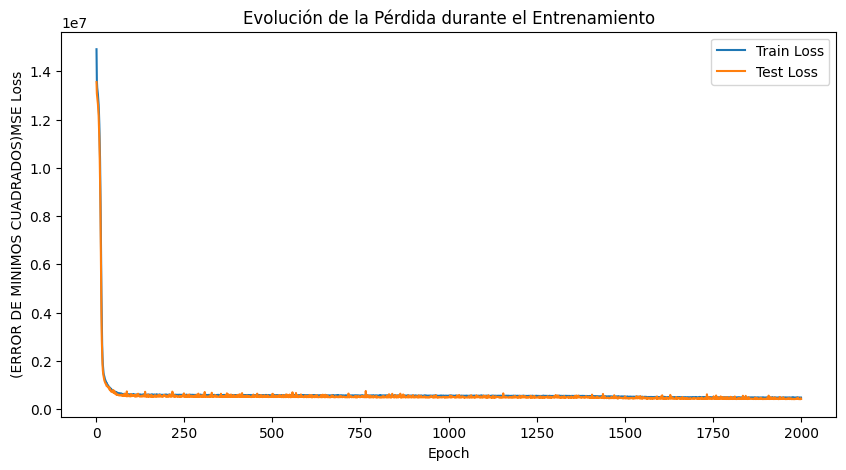

In [53]:
# 9. Graficar la función de costo (pérdida) durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("(ERROR DE MINIMOS CUADRADOS)MSE Loss")
plt.title("Evolución de la Pérdida durante el Entrenamiento")
plt.legend()
plt.show()

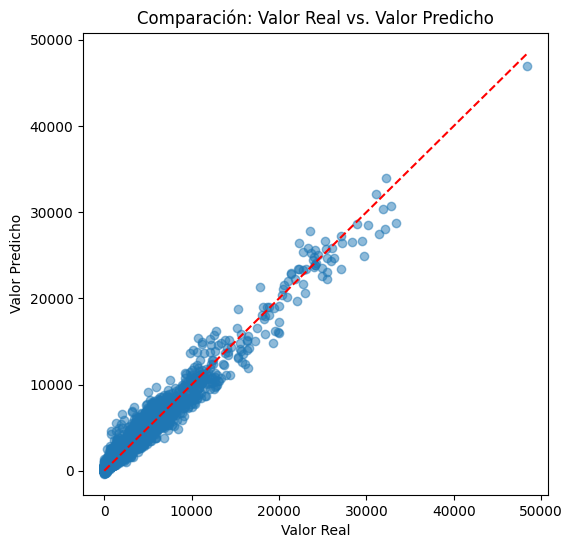

In [54]:
# 10. Graficar una comparación entre valores reales y predichos en el conjunto de prueba
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        preds = model(batch_X)
        all_preds.extend(preds.squeeze().tolist())
        all_true.extend(batch_y.squeeze().tolist())

plt.figure(figsize=(6,6))
plt.scatter(all_true, all_preds, alpha=0.5)
plt.plot([min(all_true), max(all_true)], [min(all_true), max(all_true)], color='red', linestyle='--')  # línea ideal
plt.xlabel("Valor Real")
plt.ylabel("Valor Predicho")
plt.title("Comparación: Valor Real vs. Valor Predicho")
plt.show()

**INTERPRETACION DE LOS RESULTADOS**

El modelo muestra una buena capacidad de aprendizaje y generalización, logrando reducir considerablemente la pérdida tanto en el conjunto de entrenamiento como en el de prueba. En términos cuantitativos:

La pérdida de entrenamiento disminuyó de 14,913,340.43 en la época 1 a 480,290.38 en la época 2000, lo que representa una reducción aproximada del 96.8%.

La pérdida de prueba bajó de 13,552,194.58 a 424,087.85 en el mismo intervalo, lo que equivale a una reducción del 96.9%.

Esto indica que el modelo ha aprendido de manera efectiva a minimizar el error, incluso en datos no vistos durante el entrenamiento. Puede considerarse que el entrenamiento fue exitoso, y el modelo está en condiciones de ser validado o ajustado más finamente según el caso de uso específico.

### **MODELO CLASIFICACION**

Con el mismo dataset vamos a predecir el destino que son 34 clases es decir 34 destinos posibles.
Ahora intentaremos predecir a donde esta viajando.


In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt

In [23]:
# 2. Preparar las features (X) y el target (Y)
# Se usará Destination (columna que ahora es la etiqueta) y se toman el resto de las 10 columnas como features.
# Recordar que se debe ajustar la etiqueta para que sea 0-index (suponiendo que vienen de 1 a 34):
X = df.drop("Destination", axis=1).values.astype(np.float32)
# Ajustar la etiqueta Destination: convertirla a entero y restar 1 (por ejemplo, 1 => 0, 2 => 1, etc.)
Y = (df["Destination"].values.astype(np.int64) - 1)
print("Primeros cinco ejemplos del dataset tras procesamiento para clasificación:")
print(pd.DataFrame(np.hstack([X, Y.reshape(-1, 1)]),
                  columns=df.drop("Destination", axis=1).columns.tolist() + ["Destination"]))
print("\n")

Primeros cinco ejemplos del dataset tras procesamiento para clasificación:
       Origin  Origin City  Destination City  Passengers     Seats   Flights  \
0         1.0          1.0               1.0        21.0  0.000334  0.001370   
1         2.0          2.0               2.0        41.0  0.004410  0.030137   
2         2.0          2.0               2.0        88.0  0.003809  0.026027   
3         2.0          2.0               2.0        11.0  0.000802  0.005479   
4         3.0          3.0               2.0         0.0  0.000200  0.001370   
...       ...          ...               ...         ...       ...       ...   
59995   119.0        115.0              31.0      1880.0  0.032899  0.019178   
59996   181.0        174.0              31.0        96.0  0.001114  0.001370   
59997   181.0        174.0              31.0     15142.0  0.285511  0.139726   
59998   119.0        115.0              31.0      2965.0  0.049115  0.041096   
59999   119.0        115.0              31.0 

In [24]:
# 3. Crear la clase Dataset de PyTorch
class FlightClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # Tensor de features, tamaño [N, num_features]
        self.y = torch.from_numpy(y)  # Tensor de etiquetas, tamaño [N]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = FlightClassificationDataset(X, Y)

In [25]:
# 4. Dividir el dataset en entrenamiento (90%) y prueba (10%)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [26]:
# 5. Crear DataLoaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [27]:
# 6. Definir la red neuronal para clasificación
# Suponiendo que tenemos 10 features y 34 clases de destino.
class ClassificationNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)  # salida sin softmax, ya que CrossEntropyLoss lo aplica internamente
        )

    def forward(self, x):
        return self.model(x)

In [28]:
input_dim = X.shape[1]  # 10
num_classes = 34        # según lo indicado (clases: de 1 a 34, ajustamos a 0-33)
model = ClassificationNN(input_dim, num_classes)


In [29]:
# 7. Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()  # Para clasificación
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer recomendado


En regresion se utiliza MSE(error de minimo cuadrado)
En clasificacion se usa CrossEntropyLoss(entropia cruzada) para la funcion de peridda ambos


In [30]:
# 8. Entrenamiento del modelo con registro de loss y precisión
num_epochs = 100
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)
    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # Evaluación en el conjunto de prueba
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            running_loss += loss.item() * batch_X.size(0)
            # Calcular precisión: obtener la predicción con mayor score
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    epoch_test_loss = running_loss / len(test_dataset)
    test_losses.append(epoch_test_loss)
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, " +
              f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/100, Train Loss: 8.4013, Test Loss: 3.1183, Test Accuracy: 0.3355
Epoch 10/100, Train Loss: 0.9082, Test Loss: 0.8997, Test Accuracy: 0.7445
Epoch 20/100, Train Loss: 0.5535, Test Loss: 0.4416, Test Accuracy: 0.8725
Epoch 30/100, Train Loss: 0.5335, Test Loss: 0.3581, Test Accuracy: 0.8822
Epoch 40/100, Train Loss: 0.2439, Test Loss: 0.2228, Test Accuracy: 0.9352
Epoch 50/100, Train Loss: 0.2893, Test Loss: 0.1602, Test Accuracy: 0.9482
Epoch 60/100, Train Loss: 0.1663, Test Loss: 0.1245, Test Accuracy: 0.9668
Epoch 70/100, Train Loss: 0.1017, Test Loss: 0.1622, Test Accuracy: 0.9550
Epoch 80/100, Train Loss: 0.0813, Test Loss: 0.0929, Test Accuracy: 0.9735
Epoch 90/100, Train Loss: 0.0869, Test Loss: 0.0744, Test Accuracy: 0.9807
Epoch 100/100, Train Loss: 0.0614, Test Loss: 0.0575, Test Accuracy: 0.9872


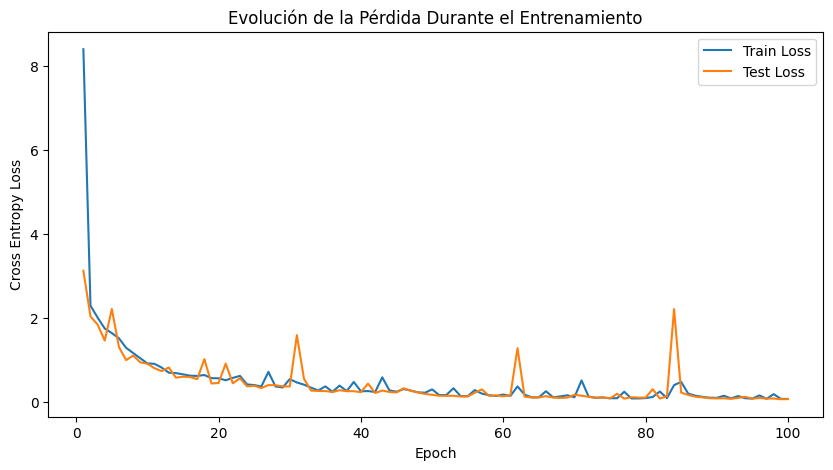

In [31]:
# 9. Graficar la función de costo (pérdida) durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Evolución de la Pérdida Durante el Entrenamiento")
plt.legend()
plt.show()

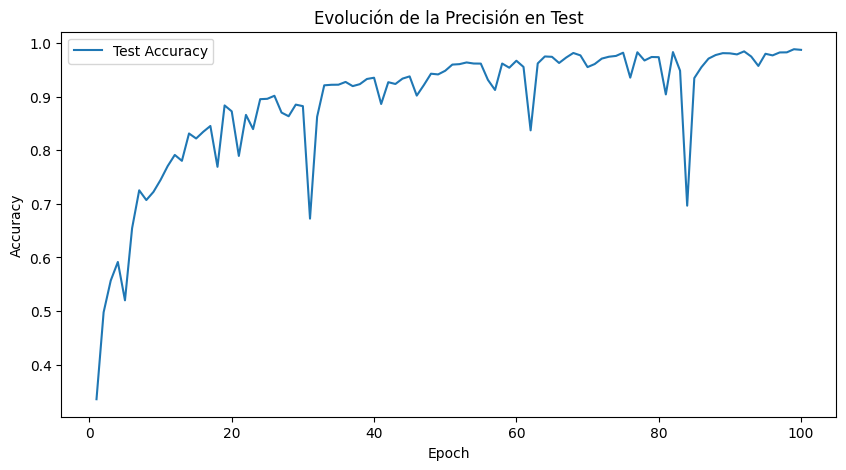

In [32]:
# 10. Graficar la evolución de la precisión en el conjunto de prueba
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evolución de la Precisión en Test")
plt.legend()
plt.show()

# **INTERPRETACION DE RESULTADOS**

El modelo de clasificación para los 34 destinos de vuelos muestra un rendimiento excelente. La pérdida de entrenamiento se redujo de 8.40 a 0.06, y la de prueba de 3.12 a 0.057, lo que indica un aprendizaje sólido y una buena generalización. Además, la precisión en el conjunto de prueba aumentó de 33.55% a 98.72%, demostrando que el modelo es altamente efectivo para predecir correctamente los destinos de vuelo.